In [1]:
#import packages
import pandas as pd
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request, json
import requests
import urllib.parse
import datetime
import nltk
nltk.download([
        "names",
        "stopwords",
        "averaged_perceptron_tagger",
        "vader_lexicon",
        "punkt",
        'wordnet'])
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re, string

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package names to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def get_data(url, uniqueid, startdatetime, enddatetime, cat_clnm, subcat_clnm, subsubcat_clnm, datetime_clnm):
    '''
    Inputs: 
    url - string value of SODA API url
    startdatetime & enddatetime - string values of the format 'YYYY-MM-DDTHH:MM:SS', i.e. '2019-12-31T23:59:59.000' 
                                for the beginning and end of timeframe of interest
    datetime_clnm - string value of the column name in the data for the datetime of complaint inquiry
    
    Output:
    gdf - GeoDataFrame of 311 inquiries. Geometry is point location of 311 inquiry.
    '''
    query = (url +'?'
            "$select= count(*) as count,%s as cat, %s as subcat, %s as subsubcat"
            "&$where=%s between '"+startdatetime+"' and '"+enddatetime+"'"
            "&$group=cat,subcat,subsubcat"
            "&$order=count DESC"
            "&$limit=500000"
            )%(cat_clnm,subcat_clnm,subsubcat_clnm,datetime_clnm)
    query = query.replace(" ", "%20")
    print(query)
    response = urllib.request.urlopen(query)
    data = json.loads(response.read())
    
    return data

In [3]:
all311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
uniqueid = 'unique_key'
cat_clnm = 'agency_name'
subcat_clnm = 'complaint_type'
subsubcat_clnm = 'descriptor'
datetime_clnm = 'created_date'

data = get_data(all311, uniqueid, '2019-01-01T00:00:00.000', '2020-01-01T00:00:00.000', cat_clnm, subcat_clnm, subsubcat_clnm, datetime_clnm)

https://data.cityofnewyork.us/resource/erm2-nwe9.json?$select=%20count(*)%20as%20count,agency_name%20as%20cat,%20complaint_type%20as%20subcat,%20descriptor%20as%20subsubcat&$where=created_date%20between%20'2019-01-01T00:00:00.000'%20and%20'2020-01-01T00:00:00.000'&$group=cat,subcat,subsubcat&$order=count%20DESC&$limit=500000


In [4]:
agg_311_cats = pd.DataFrame(data, columns = data[0].keys())
agg_311_cats.head()

,count,cat,subcat,subsubcat
0,214808,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection
1,147964,New York City Police Department,Noise - Residential,Loud Music/Party
2,137887,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING
3,98815,New York City Police Department,Blocked Driveway,No Access
4,77815,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party


In [5]:
len(agg_311_cats)

1977

In [6]:
agg_311_cats.dtypes

count        object
cat          object
subcat       object
subsubcat    object
dtype: object

In [7]:
agg_311_cats['count'] = agg_311_cats['count'].astype(int)

In [8]:
complaint_type_agg = agg_311_cats[['subcat','count']].groupby(by = 'subcat').sum().reset_index()
complaint_type_agg.sort_values(by = 'count',ascending = False).head(10)

,subcat,count
258,Noise - Residential,232850
286,Request Large Bulky Item Collection,214808
163,HEAT/HOT WATER,212565
181,Illegal Parking,198346
73,Blocked Driveway,137736
259,Noise - Street/Sidewalk,97914
313,Street Condition,88460
314,Street Light Condition,68211
349,Water System,63703
334,UNSANITARY CONDITION,57867


In [9]:
complaint_type_agg.sort_values(by = 'count',ascending = False).tail(10)

,subcat,count
208,Misc. Comments' and (select...,1
209,Misc. Comments' and 6049=60...,1
210,Misc. Comments' and 7702=77...,1
211,Misc. Comments' waitfor del...,1
212,Misc. Comments'&quot;`0&amp...,1
213,Misc. Comments'(select*from...,1
214,Misc. Comments');declare @q...,1
215,Misc. Comments')waitfor del...,1
216,Misc. Comments'+(function()...,1
369,{!xmlparser v='&lt;!DOCTYPE...,1


In [10]:
len(complaint_type_agg[complaint_type_agg['count']<100])

192

In [11]:
len(complaint_type_agg)

370

In [12]:
complaint_type_filtered = complaint_type_agg[complaint_type_agg['count']>100]
complaint_type_filtered.sort_values(by = 'count',ascending = False).tail(10)

,subcat,count
71,Bike Rack Condition,151
274,Pet Shop,150
132,Elder Abuse,144
190,LinkNYC,136
165,Harboring Bees/Wasps,134
172,Home Delivered Meal - Missed Delivery,112
307,Special Natural Area District (SNAD),111
278,Posting Advertisement,110
300,Senior Center Complaint,108
323,Tattooing,104


In [13]:
complaint_type_filtered[complaint_type_filtered['subcat'].str.contains('SCRIE')]

,subcat,count
292,SCRIE,2516


In [14]:
complaint_type_filtered[complaint_type_filtered['subcat'].str.contains('DRIE')]

,subcat,count
113,DRIE,657


In [15]:
complaint_type_filtered[complaint_type_filtered['subcat'].str.contains('DOF')]

,subcat,count
100,DOF Parking - Payment Issue,1704
101,DOF Parking - Request Copy,291
102,DOF Parking - Request Status,229
103,DOF Parking - Tax Exemption,217
104,DOF Property - Owner Issue,901
105,DOF Property - Payment Issue,2609
106,DOF Property - Property Value,390
107,DOF Property - RPIE Issue,273
108,DOF Property - Reduction Issue,5737
109,DOF Property - Request Copy,3471


In [16]:
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('SCRIE','Senior Citizen Rent Increase') 
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('DRIE','Disability Rent Increase') 
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('RPIE','Real Property Income and Expense') 
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('DOF','Department of Finance')
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('DCA','Department of Consumer Affairs')
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('DOH','Department of Finance')
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('DEP','Department of Environmental Protection')
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('DPR','Department of Parks and Recreation')
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('DPR','Department of Parks and Recreation')
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('DPR','Department of Parks and Recreation')
complaint_type_filtered['subcat'] = complaint_type_filtered['subcat'].str.replace('HPD','Department of Housing Preservation and Development')

In [17]:
complaint_type_filtered[complaint_type_filtered['subcat'].str.contains('DOF')]

,subcat,count


In [18]:
complaints = complaint_type_filtered['subcat'].to_list()
print(len(complaints))

176


## Text pre-processing

Steps include (1) removing punctuation, (2) lowercasing, and (3) removing stop words.

In [19]:
# # Initialize the Porter stemmer
porter=PorterStemmer()
stop_words = set(stopwords.words('english'))
processed_comps = {}

# Preprocess the complaint types
for item in complaints:
    og_complaint = item
    # Convert the key to lowercase and remove punctuation
    item = re.sub('/', ' ', item)
    item = re.sub('-', ' ', item)
    item = item.lower().translate(str.maketrans('', '', string.punctuation))
    # Create an empty list to store the processed values
    words = item.split()
    words_no_stopwords = [word for word in words if word not in stop_words]
    item_no_stopwords = ' '.join(words_no_stopwords)
#     processed_item = porter.stem(item_no_stopwords)
    
    processed_comps[og_complaint] = item_no_stopwords

In [20]:
processed_comps

{'APPLIANCE': 'appliance',
 'Abandoned Vehicle': 'abandoned vehicle',
 'Adopt-A-Basket': 'adopt basket',
 'Advocate-Prop Refunds/Credits': 'advocate prop refunds credits',
 'Air Quality': 'air quality',
 'Animal Abuse': 'animal abuse',
 'Animal in a Park': 'animal park',
 'Animal-Abuse': 'animal abuse',
 'Asbestos': 'asbestos',
 'BEST/Site Safety': 'best site safety',
 'Beach/Pool/Sauna Complaint': 'beach pool sauna complaint',
 'Benefit Card Replacement': 'benefit card replacement',
 'Bike Rack Condition': 'bike rack condition',
 'Bike/Roller/Skate Chronic': 'bike roller skate chronic',
 'Blocked Driveway': 'blocked driveway',
 'Boilers': 'boilers',
 'Borough Office': 'borough office',
 'Bridge Condition': 'bridge condition',
 'Broken Parking Meter': 'broken parking meter',
 'Building Marshals office': 'building marshals office',
 'Building/Use': 'building use',
 'Bus Stop Shelter Complaint': 'bus stop shelter complaint',
 'Bus Stop Shelter Placement': 'bus stop shelter placement',
 '

In [21]:
#manually update a few
processed_comps.update({'Green Taxi Complaint':'taxi'})
processed_comps.update({'Taxi Complaint':'taxi'})
processed_comps.update({'Taxi Compliment':'taxi'})
processed_comps.update({'Taxi Report':'taxi'})
processed_comps.update({'Bus Stop Shelter Placement':'bus stop shelter'})
processed_comps.update({'Bus Stop Shelter Complaint':'bus stop shelter'})
processed_comps.update({'Collection Truck Noise':'noise'})
processed_comps.update({'Noise - Commercial':'noise'})
processed_comps.update({'Noise - Helicopter':'noise'})
processed_comps.update({'Noise - House of Worship':'noise'})
processed_comps.update({'Noise - Park':'noise'})
processed_comps.update({'Noise - Residential':'noise'})
processed_comps.update({'Noise - Street/Sidewalk':'noise'})
processed_comps.update({'Noise - Vehicle':'noise'})
processed_comps.update({'Noise':'noise'})
processed_comps.update({'Root/Sewer/Sidewalk Condition':'sewer'})
processed_comps.update({'Damaged Tree':'tree'})
processed_comps.update({'Dead/Dying Tree':'tree'})
processed_comps.update({'Illegal Tree Damage':'tree'})
processed_comps.update({'New Tree Request':'tree'})
processed_comps.update({'Scaffold Safety':'scaffold'})
processed_comps.update({'Water Quality':'water quality'})
processed_comps.update({'Drinking Water':'water quality'})
processed_comps.update({'Air Quality':'air quality'})
processed_comps.update({'Derelict Vehicle':'abandoned vehicle'})
processed_comps.update({'Derelict Vehicles':'abandoned vehicle'})
processed_comps.update({'Abandoned Vehicle':'abandoned vehicle'})
processed_comps.update({'School Maintenance':'school'})
processed_comps.update({'Violation of Park Rules': 'violation park rule'})
processed_comps.update({'Asbestos': 'asbestos'})
processed_comps.update({'Indoor Air Quality': 'air quality',})
processed_comps.update({'Indoor Sewage': 'sewage'})
processed_comps.update({'Industrial Waste': 'waste'})
processed_comps.update({'Electronics Waste Appointment': 'waste'})
processed_comps.update({'Request Large Bulky Item Collection': 'bulky item'})
processed_comps.update({'Construction Safety Enforcement': 'construction'})
processed_comps.update({'Construction Safety Enforcement': 'construction'})
processed_comps.update({'Tattooing': 'tattoo'})
processed_comps.update({'Missed Collection (All Materials)':'missed collection'})
processed_comps.update({'Homeless Person Assistance': 'homeless assistance'})

In [22]:
complaints_final = set(list(processed_comps.values()))
len(complaints_final)

149

In [23]:
#import the call complaints
call_comps = pd.read_csv('../Outputs/311calls_complaints_vadar_results.csv', index_col = 0)
call_comps.head()

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
0,84545,Department of Finance,Parking Ticket Lookup - Ticket or Plate Number...,Status of a parking ticket. Must know ticket o...,Department of Finance Parking Ticket Lookup - ...,department of finance parking ticket lookup - ...,department finance parking vehicles ticket loo...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.000,0.874,0.126,0.1531
1,76516,3-1-1 Call Center,Service Request Status - General,Status of most Service Requests filed with 311.,3-1-1 Call Center Service Request Status - Gen...,3-1-1 call center service request status - gen...,call center service request status general sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,60523,Department of Finance,Property Tax Account Assistance and Bill Infor...,Help with questions about the property tax bil...,Department of Finance Property Tax Account Ass...,department of finance property tax account ass...,department finance property building tax accou...,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.000,0.876,0.124,0.4019
3,57674,NaN,Bulk Item Disposal,"Learn how to get rid of bulk items. Schedule, ...",Bulk Item Disposal Learn how to get rid of bu...,bulk item disposal learn how to get rid of bu...,bulk item disposal learn get rid bulk items sc...,"{'neg': 0.111, 'neu': 0.889, 'pos': 0.0, 'comp...",0.111,0.889,0.000,-0.2500
4,57213,NaN,Heat or Hot Water Complaint in a Residential B...,Report a problem with heat or hot water in a r...,Heat or Hot Water Complaint in a Residential ...,heat or hot water complaint in a residential ...,heat hot water complaint residential building ...,"{'neg': 0.308, 'neu': 0.692, 'pos': 0.0, 'comp...",0.308,0.692,0.000,-0.5994


In [24]:
len(call_comps[call_comps['count']>100])

2772

In [25]:
call_comps = call_comps[call_comps['count']>100]
call_comps['subcat'] = call_comps['subcat'].str.replace('SCRIE','Senior Citizen Rent Increase Exemption') 
call_comps['subcat'] = call_comps['subcat'].str.replace('DRIE','Disability Rent Increase Exemption') 
call_comps['subcat'] = call_comps['subcat'].str.replace('RPIE','Real Property Income and Expense') 
call_comps['subcat'] = call_comps['subcat'].str.replace('DOF','Department of Finance')
call_comps['subcat'] = call_comps['subcat'].str.replace('DCA','Department of Consumer Affairs')
call_comps['subcat'] = call_comps['subcat'].str.replace('DOH','Department of Finance')
call_comps['subcat'] = call_comps['subcat'].str.replace('DEP','Department of Environmental Protection')
call_comps['subcat'] = call_comps['subcat'].str.replace('DPR','Department of Parks and Recreation')
call_comps['subcat'] = call_comps['subcat'].str.replace('DPR','Department of Parks and Recreation')
call_comps['subcat'] = call_comps['subcat'].str.replace('DPR','Department of Parks and Recreation')
call_comps['subcat'] = call_comps['subcat'].str.replace('HPD','Department of Housing Preservation and Development')

call_cats = call_comps.subcat.unique().tolist()
print(len(call_cats))

2518


In [26]:
# # Initialize the Porter stemmer
porter=PorterStemmer()
stop_words = set(stopwords.words('english'))
processed_callcomps = {}

# Preprocess the complaint types
for item in call_cats:
    og_complaint = item
    # Convert the key to lowercase and remove punctuation
    item = re.sub('/', ' ', item)
    item = re.sub('-', ' ', item)
    item = item.lower().translate(str.maketrans('', '', string.punctuation))
    # Create an empty list to store the processed values
    words = item.split()
    words_no_stopwords = [word for word in words if word not in stop_words]
    item_no_stopwords = ' '.join(words_no_stopwords)
#     processed_item = porter.stem(item_no_stopwords)
    
    processed_callcomps[og_complaint] = item_no_stopwords

In [27]:
processed_callcomps

{'Parking Ticket Lookup - Ticket or Plate Number Known': 'parking ticket lookup ticket plate number known',
 'Service Request Status - General': 'service request status general',
 'Property Tax Account Assistance and Bill Information': 'property tax account assistance bill information',
 'Bulk Item Disposal': 'bulk item disposal',
 'Heat or Hot Water Complaint in a Residential Building': 'heat hot water complaint residential building',
 'Noise from Neighbor': 'noise neighbor',
 'Blocked Driveway': 'blocked driveway',
 'Parking Ticket or Camera Violation Status': 'parking ticket camera violation status',
 'Service Request Status': 'service request status',
 'Apartment Maintenance Complaint': 'apartment maintenance complaint',
 'Vehicle Blocking Driveway Complaint': 'vehicle blocking driveway complaint',
 'Find a Towed Vehicle - Plate Number Known': 'find towed vehicle plate number known',
 'Bulk Item Pick Up - Appointment': 'bulk item pick appointment',
 'Birth Certificate Order': 'birt

In [28]:
callcomplaints_final = set(list(processed_callcomps.values()))
len(callcomplaints_final)

2499

### Lets try to map the call complaints to the 311 service request subcats

The logic here is:

1. If subcat contains 1 word, search for word in the processed_callcomps. If the word exists, make key = subcat and value = proccessed_callcomps and append it to the mapping dictionary

2. If subcat is between 2 and 3 words, each word must appear in processed_callcomps to be appending in the mapping dictionary

3. If subcat is more than 3 words, at least 50% of the words must appear in the proccessed_callcomps to append in the mapping dictionary

4. else append to the list of unmapped_callcomps

In [29]:
mapping = {}
unmapped_callcomps = []

for callcomp in callcomplaints_final:
    callcomp_words = callcomp.split()
    already_mapped = False
    for comp in complaints_final:
        comp_words = comp.split()
        if len(comp_words)<= len(callcomp_words):
            if len(comp_words) == 1:
                if comp_words[0] in callcomp_words:
                    if comp in mapping:
                        if callcomp not in mapping[comp]:
                            mapping[comp].append(callcomp)
                        already_mapped = True
                    else:
                        mapping[comp] = [callcomp]
                        already_mapped = True
            elif (len(comp_words) <= 3) and (len(comp_words) > 1):
                matching_words = [word for word in comp_words if word in callcomp_words]
                if len(matching_words) == len(comp_words):
                    if comp in mapping:
                        if callcomp not in mapping[comp]:
                            mapping[comp].append(callcomp)
                        already_mapped = True
                    else:
                        mapping[comp] = [callcomp]
                        already_mapped = True
            else:
                matching_words = [word for word in comp_words if word in callcomp_words]
                if len(matching_words) >= int(len(comp_words)/2)+1:
                    if comp in mapping:
                        if callcomp not in mapping[comp]:
                            mapping[comp].append(callcomp)
                        already_mapped = True
                    else:
                        mapping[comp] = [callcomp]
                        already_mapped = True
            if already_mapped:
                break
        elif len(comp_words)> len(callcomp_words):
            if len(callcomp_words) == 1:
                if callcomp_words[0] in comp_words:
                    if comp in mapping:
                        if callcomp not in mapping[comp]:
                            mapping[comp].append(callcomp)
                        already_mapped = True
                    else:
                        mapping[comp] = [callcomp]
                        already_mapped = True
            elif (len(callcomp_words) <= 3) and (len(callcomp_words) > 1):
                matching_words = [word for word in callcomp_words if word in comp_words]
                if len(matching_words) == len(callcomp_words):
                    if comp in mapping:
                        if callcomp not in mapping[comp]:
                            mapping[comp].append(callcomp)
                        already_mapped = True
                    else:
                        mapping[comp] = [callcomp]
                        already_mapped = True
            else:
                matching_words = [word for word in callcomp_words if word in comp_words]
                if len(matching_words) >= int(len(callcomp_words)/2)+1:
                    if comp in mapping:
                        if callcomp not in mapping[comp]:
                            mapping[comp].append(callcomp)
                        already_mapped = True
                    else:
                        mapping[comp] = [callcomp]
                        already_mapped = True
            if already_mapped:
                break
    else:
        unmapped_callcomps.append(callcomp)


In [30]:
mapping

{'traffic': ['traffic non emergency condition',
  'traffic pedestrian signal wires exposed priority',
  'service request status dot traffic signal',
  'traffic pedestrian signal new timing review',
  'traffic condition',
  'traffic violation pay ticket',
  'traffic emergency condition',
  'traffic pedestrian signal complaint',
  'traffic conditions new york metro area',
  'traffic pedestrian signal pole priority',
  'traffic pedestrian signal condition',
  'traffic ticket information',
  'high grass weeds landscaped traffic island median',
  'high grass weeds unlandscaped traffic island median',
  'truck traffic rules routes',
  'new york city traffic rules',
  'traffic pedestrian signal request',
  'traffic violation fight ticket appeal hearing decision',
  'traffic ticket',
  'traffic rules',
  'interpreting parking traffic sign regulation'],
 'department housing preservation development literature request': ['department housing preservation development section 8 housing quality stan

In [31]:
len(set(unmapped_callcomps))

1926

In [32]:
set(unmapped_callcomps)

{'become nurse',
 'affordable housing',
 'literacy ged tasc instruction non english speakers',
 'drivers license',
 'basement apartment conversion pilot program spanish assistance',
 'shred fest',
 'investigate business licensed department consumer affairs',
 'car service company complaint rude discourteous',
 'sidewalk utility hardware complaint',
 'curb complaint',
 'non driver id card',
 'lewd act',
 'tour guide bus complaint',
 'department health clinics',
 'towed vehicle reclaim marshal sheriff',
 'idnyc complaints status questions',
 'verizon city wide cable tv franchise',
 'legal assistance',
 'blocked sidewalk high grass weeds',
 'marriage foreign country',
 'street line marking missing repaving',
 'property tax exemption initial application sche',
 'find public swimming pool',
 'city state jury duty bronx',
 'nyc care',
 'illegal dumping tip form',
 'fire hydrant running',
 'street utility hardware complaint',
 'public beach complaint',
 'laundry complaint',
 'storefront awnin

In [33]:
values_to_remove_drinking = ['illness caused by drinking wat','drinking wat','drinking water inform']
# Remove the values for key 'drinking'
mapping['drinking'] = [value for value in mapping['drinking'] if value not in values_to_remove_drinking]
mapping['water quality'] += values_to_remove_drinking

In [34]:
set(complaints_final)-set(list(mapping.keys()))

{'adopt basket',
 'best site safety',
 'bike rack condition',
 'bike roller skate chronic',
 'boilers',
 'broken parking meter',
 'building marshals office',
 'building use',
 'bulky item',
 'cranes derricks',
 'department finance parking payment issue',
 'department finance property owner issue',
 'department finance property payment issue',
 'department finance property reduction issue',
 'department finance property update account',
 'derelict bicycle',
 'dirty conditions',
 'door window',
 'emergency response team ert',
 'executive inspections',
 'facades',
 'ferry inquiry',
 'flooring stairs',
 'forms',
 'general construction plumbing',
 'harboring bees wasps',
 'highway condition',
 'hire vehicle complaint',
 'hire vehicle report',
 'investigations discipline iad',
 'maintenance facility',
 'mobile food vendor',
 'non emergency police matter',
 'overflowing litter baskets',
 'overgrown tree branches',
 'paint plaster',
 'pet shop',
 'posting advertisement',
 'public payphone comp

In [35]:
def map_leftovers(syns_dict, unmapped_ls):
    leftovers_mapped = {}
    for key, values in syns_dict.items():
        for value in values:
            for i in range(len(unmapped_ls)):
                words = unmapped_ls[i].split()
                if value in words:
                    if key not in leftovers_mapped:
                        leftovers_mapped[key] = []
                    leftovers_mapped[key].append(unmapped_ls[i])
    for key, values in leftovers_mapped.items():
        for value in values:
            if value in unmapped_ls:
                unmapped_ls.remove(value)
    return leftovers_mapped, unmapped_ls

In [36]:
# leftovers_mapped = {}
unmapped_callcomps_copy = unmapped_callcomps
syns_dict = {'adopt basket': ['adopt a basket', 'adopt-a-basket'],
           'best site safety': ['site safety'],
           'bike rack condition': ['bike rack'],
           'boilers': ['boiler'],
             'waste': ['dumpster overflowing','dumpster','trash'],
            'sewer': ['catch basin'],
           'broken parking meter': ['parking meter'],
           'bulky item': ['bulky', 'large item','bulk'],
           'dep street condition': ['street condition','street conditions','highway conditions','highway condition'],
           'derelict bicycle': ['abandoned bike','abandoned bicycle','derelict bike'],
           'dirty conditions': ['unsanitary condition','unsanitary conditions','dirty condition'],
           'door window': ['door','window'],
           'emergency response team ert': ['emergeny response'],
           'executive inspections': ['inspections'],
           'facades': ['building facade','facade'],
           'ferry inquiry': ['ferry'],
           'flooring stairs': ['flooring','stairs'],
           'forms': ['form','paperwork','paper work','application'],
           'found property': ['lost and found'],
           'general construction plumbing': ['plumbing'],
           'harboring bees wasps': ['bees','wasp','bee','wasps'],
           'highway condition': ['highway'],
           'hire vehicle complaint': ['taxi','hire vehicle','hire vehicles'],
           'hire vehicle report': ['taxi','hire vehicle','hire vehicles'],
           'hpd literature request': ['literature request'],
           'missed collection materials': ['missed collection', 'miss trash','missed trash','missed waste'],
           'mobile food vendor': ['food vendor','food vending'],
           'non emergency police matter': ['police'],
           'homeless encampment': ['homeless','encampment','encamp','homelessness'],
             'drug activity': ['drug','drugs'],
           'overflowing litter baskets': ['litter baskets'],
           'overgrown tree branches': ['tree'],
           'public payphone complaint': ['payphone'],
           'question': ['general inquiry'],
           'recycling enforcement': ['recycling'],
           'sanitation condition': ['sanitation'],
           'sidewalk condition': ['sidewalk','curb'],
           'street light condition': ['street light','streetlight', 'lamp post','lamppost'],
           'sweeping missed': ['street cleaning missed', 'missed street cleaning','missed sweeping'],
           'traffic signal condition': ['traffic light','traffic signal'],
           'unsanitary animal pvt property': ['unsanitary'],
           'unsanitary condition': ['unsanitary'],
           'unsanitary pigeon condition': ['unsanitary'],
           'violation park rule': ['park rule violation','park rule','park violation'],
          }

leftovers_mapped, unmapped = map_leftovers(syns_dict, unmapped_callcomps_copy)

In [37]:
leftovers_mapped

{'boilers': ['boiler inspection',
  'boiler permits registration',
  'annual boiler inspection',
  'boiler defective without permit',
  'boiler inspection violation',
  'boiler complaint',
  'boiler inspection notice violation',
  'boiler registration'],
 'waste': ['blocked street garbage merchandise dumpster trash',
  'dumpster debris container permit',
  'dumpster complaint',
  'dumpster permit',
  'dumpster overflowing',
  'new trash collection residential non profit',
  'improper trash disposal',
  'loose trash',
  'blocked street garbage merchandise dumpster trash',
  'lost item trash',
  'recycling trash collection schedules',
  'improper trash disposal uncovered partially covered mattress box spring'],
 'bulky item': ['bulk item pick appointment',
  'bulk item disposal information',
  'bulk item pick appointment status',
  'bulk item disposal',
  'department sanitation literature bulk order',
  'bulk item pick appointment cancellation rescheduling'],
 'door window': ['window gua

In [38]:
len(set(unmapped))

1724

In [39]:
mapping_final = {}

# combine values for overlapping keys
for key in mapping.keys() & leftovers_mapped.keys():
    mapping_final[key] = mapping[key] + leftovers_mapped[key]

# add remaining keys from dict1
for key in mapping.keys() - leftovers_mapped.keys():
    mapping_final[key] = mapping[key]

# add remaining keys from dict2
for key in leftovers_mapped.keys() - mapping.keys():
    mapping_final[key] = leftovers_mapped[key]

print(mapping_final)

{'waste': ['commercial waste disposal', 'special waste disposal', 'dog animal waste private property', 'e waste pickup appointment cancellation status rescheduling', 'dog waste street sidewalk adjoining area', 'e waste pickup appointment', 'special waste disposal locations rules', 'dog animal waste', 'commercial waste private carters information', 'medical waste disposal', 'blocked street garbage merchandise dumpster trash', 'dumpster debris container permit', 'dumpster complaint', 'dumpster permit', 'dumpster overflowing', 'new trash collection residential non profit', 'improper trash disposal', 'loose trash', 'blocked street garbage merchandise dumpster trash', 'lost item trash', 'recycling trash collection schedules', 'improper trash disposal uncovered partially covered mattress box spring'], 'drug activity': ['drug activity use inside progress', 'drug activity use progress', 'drug activity sale indoor progress', 'drug activity use sale outside progress', 'drug activity sale progres

In [40]:
len(set(complaints_final)-set(list(mapping_final.keys())))

43

In [41]:
len(set(complaints_final))

149

In [42]:
## Map our dictionaries to the complaint_type_filtered dataframe
complaint_type_filtered['subcat_processed'] = complaint_type_filtered['subcat'].map(processed_comps)
# complaint_type_filtered['callcomp_subcat'] = complaint_type_filtered['subcat_processed'].map(mapping_final)
complaint_type_filtered.head()

,subcat,count,subcat_processed
44,APPLIANCE,10211,appliance
45,Abandoned Vehicle,24179,abandoned vehicle
46,Adopt-A-Basket,215,adopt basket
56,Advocate-Prop Refunds/Credits,170,advocate prop refunds credits
59,Air Quality,8047,air quality


In [43]:
call_comps['subcat_processed'] = call_comps['subcat'].map(processed_callcomps)
call_comps.head(20)

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound,subcat_processed
0,84545,Department of Finance,Parking Ticket Lookup - Ticket or Plate Number...,Status of a parking ticket. Must know ticket o...,Department of Finance Parking Ticket Lookup - ...,department of finance parking ticket lookup - ...,department finance parking vehicles ticket loo...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.000,0.874,0.126,0.1531,parking ticket lookup ticket plate number known
1,76516,3-1-1 Call Center,Service Request Status - General,Status of most Service Requests filed with 311.,3-1-1 Call Center Service Request Status - Gen...,3-1-1 call center service request status - gen...,call center service request status general sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,service request status general
2,60523,Department of Finance,Property Tax Account Assistance and Bill Infor...,Help with questions about the property tax bil...,Department of Finance Property Tax Account Ass...,department of finance property tax account ass...,department finance property building tax accou...,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.000,0.876,0.124,0.4019,property tax account assistance bill information
3,57674,NaN,Bulk Item Disposal,"Learn how to get rid of bulk items. Schedule, ...",Bulk Item Disposal Learn how to get rid of bu...,bulk item disposal learn how to get rid of bu...,bulk item disposal learn get rid bulk items sc...,"{'neg': 0.111, 'neu': 0.889, 'pos': 0.0, 'comp...",0.111,0.889,0.000,-0.2500,bulk item disposal
4,57213,NaN,Heat or Hot Water Complaint in a Residential B...,Report a problem with heat or hot water in a r...,Heat or Hot Water Complaint in a Residential ...,heat or hot water complaint in a residential ...,heat hot water complaint residential building ...,"{'neg': 0.308, 'neu': 0.692, 'pos': 0.0, 'comp...",0.308,0.692,0.000,-0.5994,heat hot water complaint residential building
5,55351,NaN,Noise from Neighbor,Report a noisy neighbor.,Noise from Neighbor Report a noisy neighbor.,noise from neighbor report a noisy neighbor.,noise neighbor report noisy neighbor,"{'neg': 0.298, 'neu': 0.702, 'pos': 0.0, 'comp...",0.298,0.702,0.000,-0.1779,noise neighbor
6,55032,NaN,Blocked Driveway,Report a vehicle that is blocking your driveway.,Blocked Driveway Report a vehicle that is blo...,blocked driveway report a vehicle that is blo...,blocked driveway report vehicle blocking driveway,"{'neg': 0.54, 'neu': 0.46, 'pos': 0.0, 'compou...",0.540,0.460,0.000,-0.5719,blocked driveway
7,54232,NaN,Parking Ticket or Camera Violation Status,Look up information about your parking or came...,Parking Ticket or Camera Violation Status Loo...,parking ticket or camera violation status loo...,parking vehicles ticket camera violation statu...,"{'neg': 0.399, 'neu': 0.601, 'pos': 0.0, 'comp...",0.399,0.601,0.000,-0.8519,parking ticket camera violation status
8,52887,NaN,Service Request Status,Check the status of a Service Request filed wi...,Service Request Status Check the status of a ...,service request status check the status of a ...,service request status check status service re...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,service request status
9,52218,NaN,Apartment Maintenance Complaint,Report a maintenance problem in a privately-ow...,Apartment Maintenance Complaint Report a main...,apartment maintenance complaint report a main...,apartment maintenance complaint report mainten...,"{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'comp...",0.412,0.588,0.000,-0.5994,apartment maintenance complaint


In [44]:
calls_to_servreq = {}
for key, values in mapping_final.items():
    for value in values:
        calls_to_servreq[value] = key

print(calls_to_servreq)

{'commercial waste disposal': 'waste', 'special waste disposal': 'waste', 'dog animal waste private property': 'waste', 'e waste pickup appointment cancellation status rescheduling': 'waste', 'dog waste street sidewalk adjoining area': 'waste', 'e waste pickup appointment': 'waste', 'special waste disposal locations rules': 'waste', 'dog animal waste': 'waste', 'commercial waste private carters information': 'waste', 'medical waste disposal': 'waste', 'blocked street garbage merchandise dumpster trash': 'waste', 'dumpster debris container permit': 'waste', 'dumpster complaint': 'waste', 'dumpster permit': 'waste', 'dumpster overflowing': 'waste', 'new trash collection residential non profit': 'waste', 'improper trash disposal': 'waste', 'loose trash': 'waste', 'lost item trash': 'waste', 'recycling trash collection schedules': 'recycling enforcement', 'improper trash disposal uncovered partially covered mattress box spring': 'waste', 'drug activity use inside progress': 'drug activity'

In [45]:
len(calls_to_servreq.keys())

778

In [46]:
call_comps['subcat_servreq'] = call_comps['subcat_processed'].map(calls_to_servreq)

In [47]:
call_comps.head()

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound,subcat_processed,subcat_servreq
0,84545,Department of Finance,Parking Ticket Lookup - Ticket or Plate Number...,Status of a parking ticket. Must know ticket o...,Department of Finance Parking Ticket Lookup - ...,department of finance parking ticket lookup - ...,department finance parking vehicles ticket loo...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.000,0.874,0.126,0.1531,parking ticket lookup ticket plate number known,NaN
1,76516,3-1-1 Call Center,Service Request Status - General,Status of most Service Requests filed with 311.,3-1-1 Call Center Service Request Status - Gen...,3-1-1 call center service request status - gen...,call center service request status general sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,service request status general,general
2,60523,Department of Finance,Property Tax Account Assistance and Bill Infor...,Help with questions about the property tax bil...,Department of Finance Property Tax Account Ass...,department of finance property tax account ass...,department finance property building tax accou...,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.000,0.876,0.124,0.4019,property tax account assistance bill information,NaN
3,57674,NaN,Bulk Item Disposal,"Learn how to get rid of bulk items. Schedule, ...",Bulk Item Disposal Learn how to get rid of bu...,bulk item disposal learn how to get rid of bu...,bulk item disposal learn get rid bulk items sc...,"{'neg': 0.111, 'neu': 0.889, 'pos': 0.0, 'comp...",0.111,0.889,0.000,-0.2500,bulk item disposal,bulky item
4,57213,NaN,Heat or Hot Water Complaint in a Residential B...,Report a problem with heat or hot water in a r...,Heat or Hot Water Complaint in a Residential ...,heat or hot water complaint in a residential ...,heat hot water complaint residential building ...,"{'neg': 0.308, 'neu': 0.692, 'pos': 0.0, 'comp...",0.308,0.692,0.000,-0.5994,heat hot water complaint residential building,heat hot water


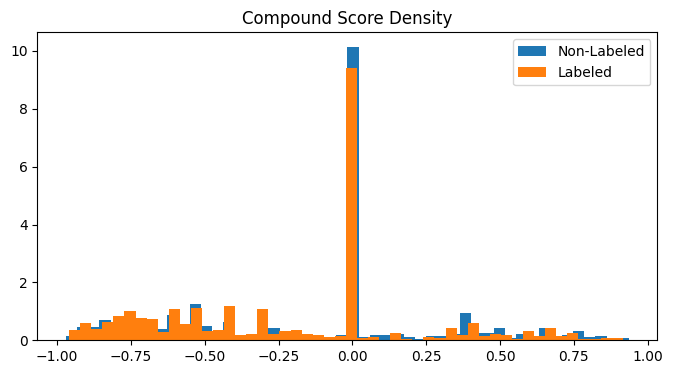

In [48]:
nonlabeled = call_comps[call_comps['subcat_servreq'].isna()]
labeled = call_comps[~call_comps['subcat_servreq'].isna()]

fig,ax = plt.subplots(figsize = (8,4))
plt.hist(nonlabeled['compound'],bins = 50,density = True,label = 'Non-Labeled')
plt.hist(labeled['compound'],bins = 50,density = True,label = 'Labeled')
plt.title('Compound Score Density')
plt.legend()
plt.show()

In [52]:
serv_req_call_sum = call_comps[['subcat_servreq','count']].groupby(by = 'subcat_servreq').sum().reset_index()
serv_req_call_sum.head()

,subcat_servreq,count
0,abandoned vehicle,43901
1,advocate prop refunds credits,276
2,air quality,2882
3,animal abuse,7723
4,animal park,629


In [57]:
weighted_avg_num = call_comps[['subcat_servreq','subcat','compound','count']].groupby(by = ['subcat_servreq','subcat']).agg({'compound':'mean','count':'sum'})
weighted_avg_num['num'] = weighted_avg_num['compound']*weighted_avg_num['count']
weighted_avg_num = weighted_avg_num.reset_index()
weighted_avg_num = weighted_avg_num[['subcat_servreq','num']].groupby(by = 'subcat_servreq').sum().reset_index()
weighted_avg_num.head(20)

,subcat_servreq,num
0,abandoned vehicle,-35431.35600
1,advocate prop refunds credits,42.25560
2,air quality,-1382.64810
3,animal abuse,-6663.79055
4,animal park,-458.75610
5,appliance,0.00000
6,asbestos,-1501.50270
7,beach pool sauna complaint,-104.72750
8,benefit card replacement,-496.10400
9,blocked driveway,-31472.80080


In [60]:
serv_req_weighted_avg = pd.merge(weighted_avg_num,serv_req_call_sum, on = 'subcat_servreq')
serv_req_weighted_avg['weighted_avg_compound'] = serv_req_weighted_avg['num']/serv_req_weighted_avg['count']
serv_req_weighted_avg.head()

,subcat_servreq,num,count,weighted_avg_compound
0,abandoned vehicle,-35431.35600,43901,-0.807074
1,advocate prop refunds credits,42.25560,276,0.153100
2,air quality,-1382.64810,2882,-0.479753
3,animal abuse,-6663.79055,7723,-0.862850
4,animal park,-458.75610,629,-0.729342


In [62]:
serv_req_weighted_avg = serv_req_weighted_avg[['subcat_servreq','weighted_avg_compound']]
complaint_type_filtered = pd.merge(complaint_type_filtered,serv_req_weighted_avg,left_on = 'subcat_processed',right_on = 'subcat_servreq')
complaint_type_filtered.head()

,subcat,count,subcat_processed,subcat_servreq,weighted_avg_compound
0,APPLIANCE,10211,appliance,appliance,0.000000
1,Abandoned Vehicle,24179,abandoned vehicle,abandoned vehicle,-0.807074
2,Derelict Vehicle,17777,abandoned vehicle,abandoned vehicle,-0.807074
3,Derelict Vehicles,36999,abandoned vehicle,abandoned vehicle,-0.807074
4,Advocate-Prop Refunds/Credits,170,advocate prop refunds credits,advocate prop refunds credits,0.153100


In [63]:
complaint_type_compound_dict = complaint_type_filtered.set_index('subcat')['weighted_avg_compound'].to_dict()
complaint_type_compound_dict

{'APPLIANCE': 0.0,
 'Abandoned Vehicle': -0.8070740074257988,
 'Derelict Vehicle': -0.8070740074257988,
 'Derelict Vehicles': -0.8070740074257988,
 'Advocate-Prop Refunds/Credits': 0.1531,
 'Air Quality': -0.47975298403886185,
 'Indoor Air Quality': -0.47975298403886185,
 'Animal Abuse': -0.86285,
 'Animal-Abuse': -0.86285,
 'Animal in a Park': -0.7293419713831478,
 'Asbestos': -0.5208125910509885,
 'Beach/Pool/Sauna Complaint': -0.19575233644859813,
 'Benefit Card Replacement': -0.27469767441860465,
 'Blocked Driveway': -0.5719,
 'Boilers': -0.627537529060113,
 'Borough Office': -0.05624012372144301,
 'Bridge Condition': -0.5267,
 'Bus Stop Shelter Complaint': -0.7441,
 'Bus Stop Shelter Placement': -0.7441,
 'Collection Truck Noise': -0.09766089463854599,
 'Noise': -0.09766089463854599,
 'Noise - Commercial': -0.09766089463854599,
 'Noise - Helicopter': -0.09766089463854599,
 'Noise - House of Worship': -0.09766089463854599,
 'Noise - Park': -0.09766089463854599,
 'Noise - Residentia

In [64]:
import pickle

with open('../Outputs/serv_req_compound_score.pickle', 'wb') as f:
    pickle.dump(complaint_type_compound_dict, f)

In [61]:
call_comps[['subcat_servreq','subcat','compound','count']].groupby(by = ['subcat_servreq','subcat']).agg({'compound':'mean','count':'sum'}).sort_values(by = 'compound',ascending = False).tail(20)

compound   
subcat_servreq              subcat                                                         
elder abuse                 Elder Abuse - Brooklyn - Senior and Customer In...   -0.9081  \
                            Elder Abuse - Bronx                                  -0.9081   
                            Elder Abuse - Queens                                 -0.9081   
sidewalk condition          Dead Animal on Street or Sidewalk - Priority         -0.9081   
outside building            Garbage or Recycling Storage Complaint - Outsid...   -0.9081   
elder abuse                 Elder Abuse - Manhattan                              -0.9081   
non emergency police matter Police Officer Complaint                             -0.9100   
boilers                     Boiler Inspection Violation                          -0.9153   
sanitation condition        Department of Sanitation Worker or Vehicle Comp...   -0.9168   
taxi                        Taxi Complaint - Broken or Missing Equipment         -0.9186   
elder abuse                 Elder Abuse - Brooklyn - Limited Information or...   -0.9231   
sanitation condition        Department of Sanitation Vehicle Accident            -0.9325   
drug activity               Drug Rehabilitation Program Complaint                -0.9337   
food poisoning              Food Poisoning Complaint - 1 or 2 People Sick        -0.9360   
                            Food Poisoning Complaint - 3 or More People Sick     -0.9360   
sidewalk condition          Dispute New Sidewalk Violation - Reinspection R...   -0.9382   
boilers                     Boiler Inspection Notice of Violation                -0.9432   
sanitation condition        Sanitation Vehicle Accident                          -0.9501   
school                      Public School Bullying Complaint                     -0.9571   
forms                       Illegal Dumping Tip Form                             -0.9595   

                                                                                count  
subcat_servreq              subcat                                                     
elder abuse                 Elder Abuse - Brooklyn - Senior and Customer In...    368  
                            Elder Abuse - Bronx                                   159  
                            Elder Abuse - Queens                                  220  
sidewalk condition          Dead Animal on Street or Sidewalk - Priority         6215  
outside building            Garbage or Recycling Storage Complaint - Outsid...   1728  
elder abuse                 Elder Abuse - Manhattan                               188  
non emergency police matter Police Officer Complaint                             4664  
boilers                     Boiler Inspection Violation                           251  
sanitation condition        Department of Sanitation Worker or Vehicle Comp...   3821  
taxi                        Taxi Complaint - Broken or Missing Equipment          101  
elder abuse                 Elder Abuse - Brooklyn - Limited Information or...    107  
sanitation condition        Department of Sanitation Vehicle Accident             573  
drug activity               Drug Rehabilitation Program Complaint                 101  
food poisoning              Food Poisoning Complaint - 1 or 2 People Sick        1073  
                            Food Poisoning Complaint - 3 or More People Sick      219  
sidewalk condition          Dispute New Sidewalk Violation - Reinspection R...   2468  
boilers                     Boiler Inspection Notice of Violation                 190  
sanitation condition        Sanitation Vehicle Accident                           542  
school                      Public School Bullying Complaint                      710  
forms                       Illegal Dumping Tip Form                              123